In [1]:
import os
import tensorflow as tf
import numpy as np
import visualize

# eager execution
tf.enable_eager_execution()
tf.executing_eagerly()

# tensorflow config - using one gpu and extending the GPU 
# memory region needed by the TensorFlow process
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

#### load dataset

In [2]:
from detection.datasets import coco, data_generator

In [3]:
img_mean = (123.675, 116.28, 103.53)
# img_std = (58.395, 57.12, 57.375)
img_std = (1., 1., 1.)

In [4]:
train_dataset = coco.CocoDataSet('./COCO2017/', 'train',
                                 flip_ratio=0.5,
                                 pad_mode='fixed',
                                 mean=img_mean,
                                 std=img_std,
                                 scale=(800, 1024))

train_generator = data_generator.DataGenerator(train_dataset)


loading annotations into memory...
Done (t=11.51s)
creating index...
index created!


#### display a sample

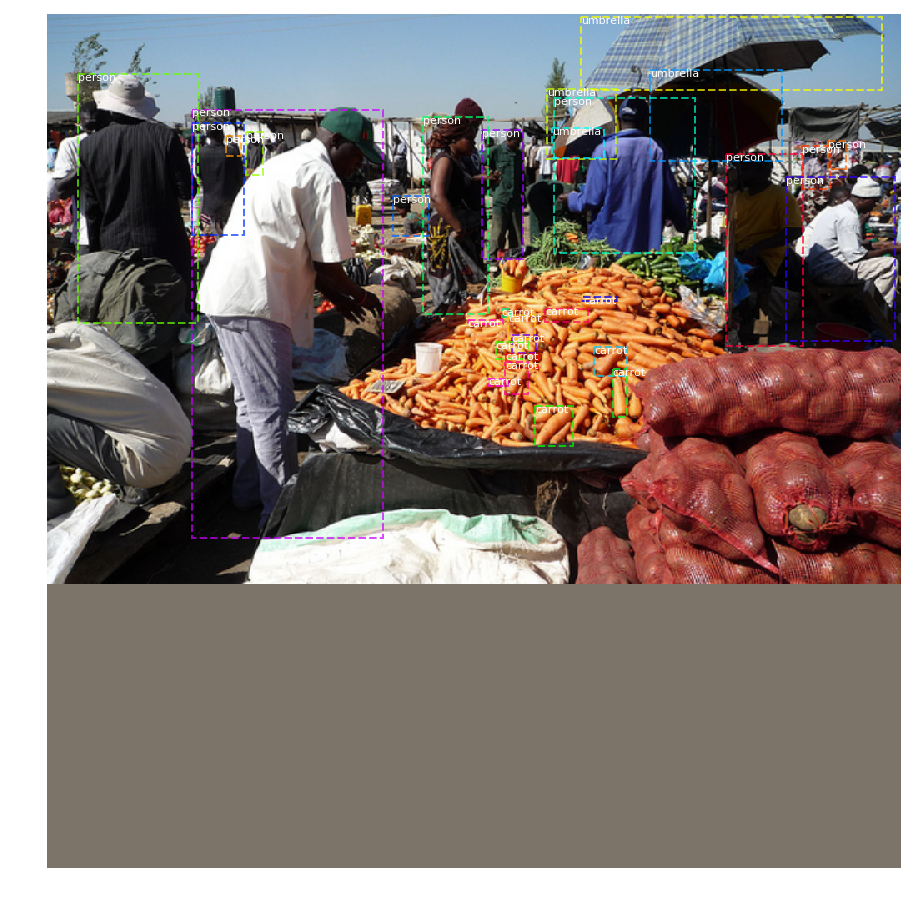

In [5]:
img, img_meta, bboxes, labels = train_dataset[0]
rgb_img = np.round(img + img_mean)
visualize.display_instances(rgb_img, bboxes, labels, train_dataset.get_categories())

#### load model

In [6]:
from detection.models.detectors import faster_rcnn

model = faster_rcnn.FasterRCNN(
    num_classes=len(train_dataset.get_categories()))

In [7]:
batch_imgs = tf.Variable(np.expand_dims(img, 0))
batch_metas = tf.Variable(np.expand_dims(img_meta, 0))

_ = model((batch_imgs, batch_metas), training=False)

In [8]:
model.load_weights('weights/faster_rcnn.h5', by_name=True)

In [9]:
res = model((batch_imgs, batch_metas), training=False)[0]

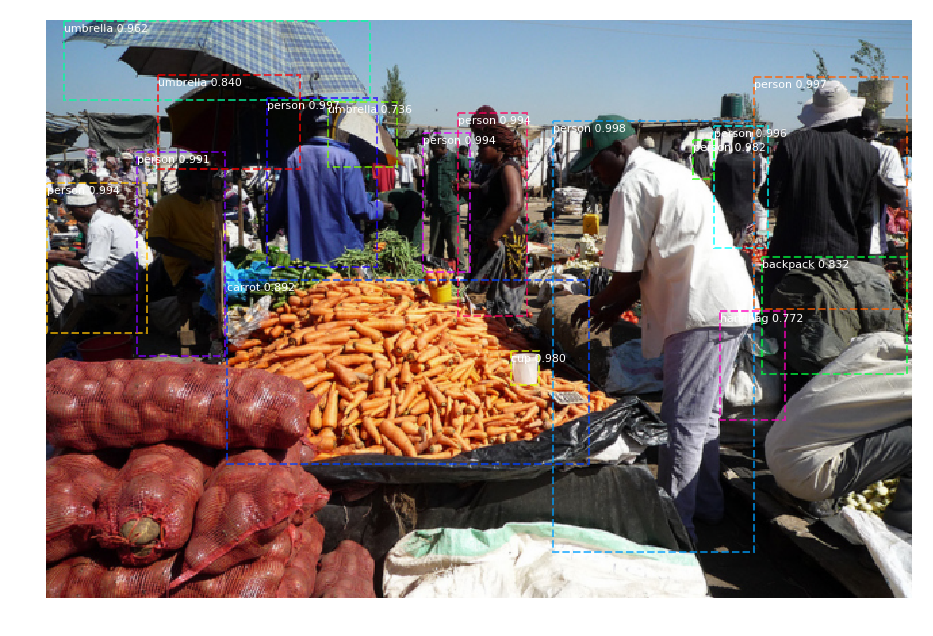

In [10]:
from detection.datasets.utils import get_original_image
ori_img = get_original_image(img, img_meta, img_mean)
visualize.display_instances(ori_img, res['rois'], res['class_ids'], 
                            train_dataset.get_categories(), scores=res['scores'])

#### use tf.data

In [11]:
batch_size = 1

train_tf_dataset = tf.data.Dataset.from_generator(
    train_generator, (tf.float32, tf.float32, tf.float32, tf.int32))
train_tf_dataset = train_tf_dataset.padded_batch(
    batch_size, padded_shapes=([None, None, None], [None], [None, None], [None]))

#### overfit a sample

In [12]:
optimizer = tf.train.MomentumOptimizer(1e-3, 0.9, use_nesterov=True)

epochs = 100

for epoch in range(epochs):
    iterator = train_tf_dataset.make_one_shot_iterator()

    loss_history = []
    for (batch, inputs) in enumerate(iterator):
    
        batch_imgs, batch_metas, batch_bboxes, batch_labels = inputs
        with tf.GradientTape() as tape:
            rpn_class_loss, rpn_bbox_loss, rcnn_class_loss, rcnn_bbox_loss = \
                model((batch_imgs, batch_metas, batch_bboxes, batch_labels), training=True)

            loss_value = rpn_class_loss + rpn_bbox_loss + rcnn_class_loss + rcnn_bbox_loss

        grads = tape.gradient(loss_value, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables),
                                  global_step=tf.train.get_or_create_global_step())

        loss_history.append(loss_value.numpy())
        break

    print('epoch', epoch, '-', np.mean(loss_history))

epoch 0 - 1.5934083
epoch 1 - 1.5524431
epoch 2 - 1.4479728
epoch 3 - 1.3514019
epoch 4 - 1.2260114
epoch 5 - 1.1722803
epoch 6 - 1.0132984
epoch 7 - 0.97030675
epoch 8 - 0.79659164
epoch 9 - 0.76209855
epoch 10 - 0.9319247
epoch 11 - 0.8842812
epoch 12 - 0.76783717
epoch 13 - 0.6013303
epoch 14 - 0.59154284
epoch 15 - 0.6638913
epoch 16 - 0.64339703
epoch 17 - 0.5604178
epoch 18 - 0.59459305
epoch 19 - 0.55089474
epoch 20 - 0.4895219
epoch 21 - 0.43150973
epoch 22 - 0.41864473
epoch 23 - 0.44893456
epoch 24 - 0.38835496
epoch 25 - 0.3976948
epoch 26 - 0.46652147
epoch 27 - 0.3629883
epoch 28 - 0.34696096
epoch 29 - 0.3368533
epoch 30 - 0.37621176
epoch 31 - 0.3467612
epoch 32 - 0.29819143
epoch 33 - 0.36289912
epoch 34 - 0.28634787
epoch 35 - 0.26583895
epoch 36 - 0.24632257
epoch 37 - 0.2588089
epoch 38 - 0.2587711
epoch 39 - 0.23057014
epoch 40 - 0.25798216
epoch 41 - 0.2989473
epoch 42 - 0.24524456
epoch 43 - 0.20397812
epoch 44 - 0.2644732
epoch 45 - 0.25416213
epoch 46 - 0.257435

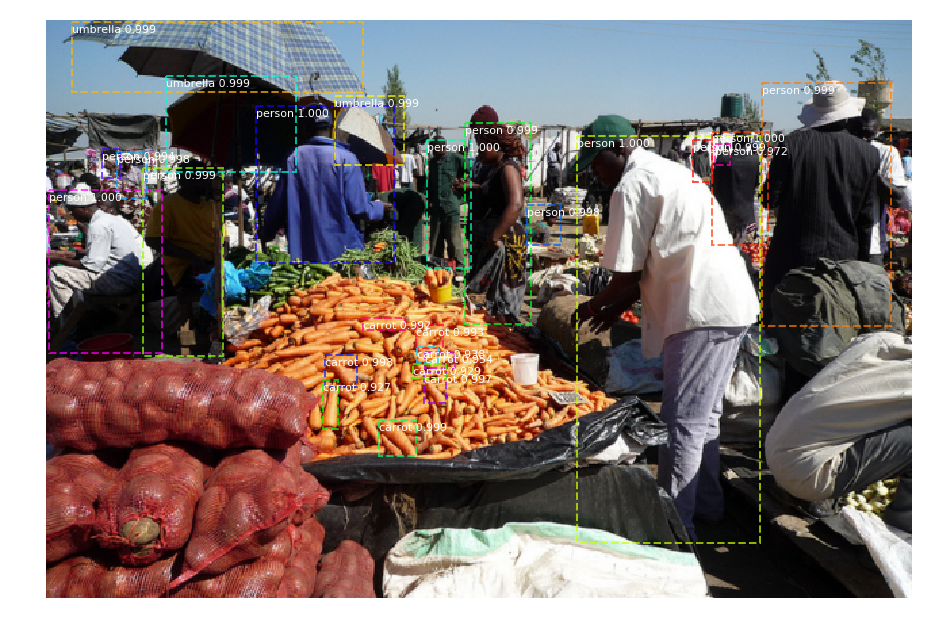

In [13]:
res = model((batch_imgs, batch_metas), training=False)[0]
ori_img = get_original_image(batch_imgs[0].numpy(), batch_metas[0].numpy(), img_mean)
visualize.display_instances(ori_img, res['rois'], res['class_ids'], 
                            train_dataset.get_categories(), scores=res['scores'])

#### train model

In [ ]:
optimizer = tf.train.MomentumOptimizer(1e-3, 0.9, use_nesterov=True)

epochs = 20

for epoch in range(epochs):
    iterator = train_tf_dataset.make_one_shot_iterator()

    loss_history = []
    for (batch, inputs) in enumerate(iterator):
    
        batch_imgs, batch_metas, batch_bboxes, batch_labels = inputs
        with tf.GradientTape() as tape:
            rpn_class_loss, rpn_bbox_loss, rcnn_class_loss, rcnn_bbox_loss = \
                model((batch_imgs, batch_metas, batch_bboxes, batch_labels), training=True)

            loss_value = rpn_class_loss + rpn_bbox_loss + rcnn_class_loss + rcnn_bbox_loss

        grads = tape.gradient(loss_value, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables),
                                  global_step=tf.train.get_or_create_global_step())

        loss_history.append(loss_value.numpy())

    print('epoch', epoch, '-', np.mean(loss_history))